In [180]:
import gurobipy as gb
import matplotlib.pyplot as plt
from scipy.spatial.distance import euclidean
import numpy as np
from itertools import combinations
from numpy.random import randint

coor = [(35,35),(45,65),(45,20),(45,10),(55,5),(65,35),
        (65,20),(45,30),(35,40),(41,37),(64,42)]
N_p = {1:[1,2,3,4,7,8,10], 2:[1,2,5,6,7,9]}
pu = {(1,1):43, (1,2):51,
      (2,1):45, (2,2):56,
      (3,1):46,
      (4,1):60,
                (5,2):50,
                (6,2):49,
      (7,1):50, (7,2):59,
      (8,1):53,
                (9,2):47,
      (10,1):54}

Q  = {(1,1):44, (1,2):56,
      (2,1):57, (2,2):40,
      (3,1):43,
      (4,1):49,
                (5,2):48,
                (6,2):44,
      (7,1):41, (7,2):46,
      (8,1):46,
                (9,2):42,
      (10,1):46}

d = {1:97.44*2.9, 2:75.32*2.5}

coor = [(35,35),(45,65),(45,20),(45,10),(55,5),(65,35)]

In [181]:
N = list(range(1,len(coor)))
V = N + [0]
A = [(i,j) for i in V for j in V if i != j]
P = [1,2]
T = list(range(4))
S = list(range(1,4))
O_p = {1:list(range(4)), 2:list(range(4))}

c = {(i,j):euclidean(coor[i],coor[j]) for (i,j) in A}
C = 375; rr = 0.05

h = {1:12.6, 2:12.46}
u = {1:21.26, 2:12.38}

N_p = {1:[2,3,4], 2:[1,2,4,5]}

pu = {(1, 2, 0): 45, (1, 2, 1): 42, (1, 2, 2): 50, (1, 2, 3): 52,
     (2, 1, 0): 54, (2, 1, 1): 43, (2, 1, 2): 47, (2, 1, 3): 45,
     (2, 2, 0): 52, (2, 2, 1): 47, (2, 2, 2): 43, (2, 2, 3): 49,
     (3, 1, 0): 45, (3, 1, 1): 44, (3, 1, 2): 44, (3, 1, 3): 47,
     (4, 1, 0): 46, (4, 1, 1): 55, (4, 1, 2): 56, (4, 1, 3): 50,
     (4, 2, 0): 51, (4, 2, 1): 55, (4, 2, 2): 46, (4, 2, 3): 43,
     (5, 2, 0): 41, (5, 2, 1): 43, (5, 2, 2): 50, (5, 2, 3): 45}

Q = {(i,p,t,s):randint(40,61) for p in P for i in N_p[p] for t in T for s in S}

d = {(p,t,s):randint(75,100) for p in P for t in T for s in S}

In [182]:
def VRP(N,V,A,P,T,S,O_p,N_p,c,pu,d,Q,h,u,C,rr,output):

    M = list()
    for r in range(2,len(N)+1):
        M += combinations(iterable = N, r = r)
    
    m = gb.Model("VRP")

    ###################################
    # Variables
    ###################################

    ''' Whether supplier i in N is visited on day t in T on sample path s in S '''
    z = {(i,t,s):m.addVar(vtype=gb.GRB.BINARY, name=f"z_{i,t,s}") for i in N for t in T for s in S}; z.update({(0,t,s):m.addVar(vtype=gb.GRB.INTEGER, name=f"z_{0,t,s}") for t in T for s in S})
    
    ''' Number of times that the arc (i,j) in A is traversed on day t in T on sample path s in S '''
    x = {(i,j,t,s):m.addVar(vtype=gb.GRB.BINARY, name=f"x_{i,j,t,s}", obj=c[i,j]) for (i,j) in A for t in T for s in S}
    
    ''' Amount of product p in P that traverses arc (i,j) in A on day t in T on sample path s in S '''
    y = {(i,j,p,t,s):m.addVar(vtype=gb.GRB.CONTINUOUS, name=f"y_{i,j,p,t,s}") for (i,j) in A for p in P for t in T for s in S}

    ''' Amount of product p in P bought from supplier i in N_p on day t in T on sample path s in S '''
    q = {(i,p,t,s):m.addVar(vtype=gb.GRB.CONTINUOUS, name=f"q_{i,p,t,s}", obj=pu[i,p,t]) for p in P for i in N_p[p] for t in T for s in S}

    ''' Inventory level of product p in P that has aged o in O_p days at the warehouse by the end of day t in T on sample path s in S '''
    I = {(p,o,t,s):m.addVar(vtype=gb.GRB.CONTINUOUS, name=f"I_{p,o,t,s}", obj=h[p]) for p in P for o in O_p[p] for t in T for s in S}
    
    ''' Amount of product p in P that has aged o in O_p days at the warehouse used to fulfill the customer's demand on day t in T on sample path s in S '''
    v = {(p,o,t,s):m.addVar(vtype=gb.GRB.CONTINUOUS, name=f"v_{p,o,t,s}") for p in P for o in O_p[p] for t in T for s in S}
    
    ''' Unfulfilled demand of product p in P on day t in T on sample path s in S '''
    b = {(p,t,s):m.addVar(vtype=gb.GRB.CONTINUOUS, name=f"b_{p,t,s}", obj=u[p]) for p in P for t in T for s in S}

    ###################################
    # Constraints
    ###################################

    for s in S:

        for p in P:
            for o in O_p[p][1:]:
                ''' Initial inventory of aged product '''
                m.addConstr(I[p,o,0,s] == 0 - v[p,o,0,s])
            
            for t in T:
                ''' Inventory of fresh product '''
                m.addConstr(I[p,0,t,s] == gb.quicksum(q[i,p,t,s] for i in N_p[p]) - v[p,0,t,s])
                
                if t >= 1:
                    for o in O_p[p][1:]:
                        ''' Inventory dynamics throughout the lookahead horizon '''
                        m.addConstr(I[p,o,t,s] == I[p,o-1,t-1,s] - v[p,o,t,s])

        for t in T:
            
            ''' Fleet size '''
            m.addConstr(z[0,t,s] <= 2)

            for i in N:
                ''' Maximum allowed total purchase at each visited supplier '''
                m.addConstr(gb.quicksum(q[i,p,t,s] for p in P if i in N_p[p]) <= C*z[i,t,s])
                
                if t >= 1:
                    ''' Minimum required purchase at each visited supplier '''
                    m.addConstr(gb.quicksum(q[i,p,t,s] for p in P if i in N_p[p]) >= rr*C*z[i,t,s])
                
                for p in P:
                    if i in N_p[p]:

                        ''' Product availability at each supplier '''
                        m.addConstr(q[i,p,t,s] <= Q[i,p,t,s]*z[i,t,s])
                        
                        ''' Flow of products at the supplier nodes '''
                        m.addConstr(gb.quicksum(y[i,j,p,t,s] for j in V if (i,j) in A) - gb.quicksum(y[j,i,p,t,s] for j in V if (j,i) in A) == q[i,p,t,s])
                    else:
                        m.addConstr(gb.quicksum(y[i,j,p,t,s] for j in V if (i,j) in A) - gb.quicksum(y[j,i,p,t,s] for j in V if (j,i) in A) == 0)
                
            for p in P:
                
                ''' Demand compliance and backorders '''
                m.addConstr(gb.quicksum(v[p,o,t,s] for o in O_p[p]) + b[p,t,s] == d[p,t,s])
                
                ''' Flow of products at the warehouse '''
                m.addConstr(gb.quicksum(y[i,0,p,t,s] for i in N) == gb.quicksum(q[i,p,t,s] for i in N_p[p]))
                m.addConstr(gb.quicksum(y[0,i,p,t,s] for i in N) == 0)
                
                ''' Flow variables association '''
                for (i,j) in A:
                    m.addConstr(y[i,j,p,t,s] <= C*x[i,j,t,s])

            for i in V:
                ''' Flow through the network '''
                m.addConstr(gb.quicksum(x[i,j,t,s] for j in V if (i,j) in A) == z[i,t,s])
                m.addConstr(gb.quicksum(x[j,i,t,s] for j in V if (j,i) in A) == z[i,t,s])
            
            for mm in M:
                ''' Subtour elimination and capacity constraints '''
                m.addConstr(C*gb.quicksum(x[i,j,t,s] for (i,j) in A if (i in mm) and (j in mm)) <= gb.quicksum(C*z[i,t,s] - gb.quicksum(q[i,p,t,s] for p in P if i in N_p[p]) for i in mm))
            
            ''' Non-anticipativity constraints '''
            for p in P:
                for i in N_p[p]:
                    m.addConstr(q[i,p,0,s] == gb.quicksum(q[i,p,0,ss] for ss in S)/len(S))
    
    ''' Service Level requirement constraints '''
    for p in P:
        m.addConstr(gb.quicksum(gb.quicksum(v[p,o,t,s] for o in O_p[p] for t in T)/sum(d[p,t,s] for t in T) for s in S) >= 1*len(S))

    ###################################
    # Objectives
    ###################################

    m.setParam("OutputFlag",output)
    m.update()
    m.optimize()

    ###################################
    # Decisions retrieval
    ###################################

    y = {s:{t:{(i,j,p):y[i,j,p,t,s].X for (i,j) in A for p in P} for t in T} for s in S}
    x = {s:{t:{(i,j):x[i,j,t,s].X for (i,j) in A} for t in T} for s in S}
    q = {s:{t:{(i,p):q[i,p,t,s].X for p in P for i in N_p[p]} for t in T} for s in S}
    z = {s:{t:{i:z[i,t,s].X for i in V} for t in T} for s in S}

    return x, y, q, z


In [185]:
x, y, q, z = VRP(N,V,A,P,T,S,O_p,N_p,c,pu,d,Q,h,u,C,rr, output = False)

for s in S:
    print(f"Sample Path {s}")
    for t in T:
        print(f"\tDay {t}")

        print("\t\tArcs decisions")
        for (i,j) in A:
            if x[s][t][i,j] > 0.5:
                print(f"\t\t\tArc {(i,j)} - ", f"Carrying {round(y[s][t][i,j,1],2)} of p1 and {round(y[s][t][i,j,2],2)} of p2")

        print("\n\t\tNode decisions")
        for i in N:
            if z[s][t][i] > 0.5:
                print(f"\t\t\tSupplier {i} - ", f"Bought {round(q[s][t][i,1],2) if i in N_p[1] else 0} of p1 and {round(q[s][t][i,2],2) if i in N_p[2] else 0} of p2")

Sample Path 1
	Day 0
		Arcs decisions
			Arc (1, 0) -  Carrying 86.0 of p1 and 91.0 of p2
			Arc (3, 4) -  Carrying 51.0 of p1 and 0.0 of p2
			Arc (4, 5) -  Carrying 86.0 of p1 and 0.0 of p2
			Arc (5, 1) -  Carrying 86.0 of p1 and 53.0 of p2
			Arc (0, 3) -  Carrying 0.0 of p1 and 0.0 of p2

		Node decisions
			Supplier 1 -  Bought 0 of p1 and 38.0 of p2
			Supplier 3 -  Bought 51.0 of p1 and 0 of p2
			Supplier 4 -  Bought 35.0 of p1 and 0.0 of p2
			Supplier 5 -  Bought 0 of p1 and 53.0 of p2
	Day 1
		Arcs decisions
			Arc (1, 5) -  Carrying 0.0 of p1 and 51.0 of p2
			Arc (2, 0) -  Carrying 79.0 of p1 and 95.0 of p2
			Arc (3, 2) -  Carrying 33.0 of p1 and 95.0 of p2
			Arc (5, 3) -  Carrying 0.0 of p1 and 95.0 of p2
			Arc (0, 1) -  Carrying 0.0 of p1 and 0.0 of p2

		Node decisions
			Supplier 1 -  Bought 0 of p1 and 51.0 of p2
			Supplier 2 -  Bought 46.0 of p1 and 0.0 of p2
			Supplier 3 -  Bought 33.0 of p1 and 0 of p2
			Supplier 5 -  Bought 0 of p1 and 44.0 of p2
	Day 2
		A

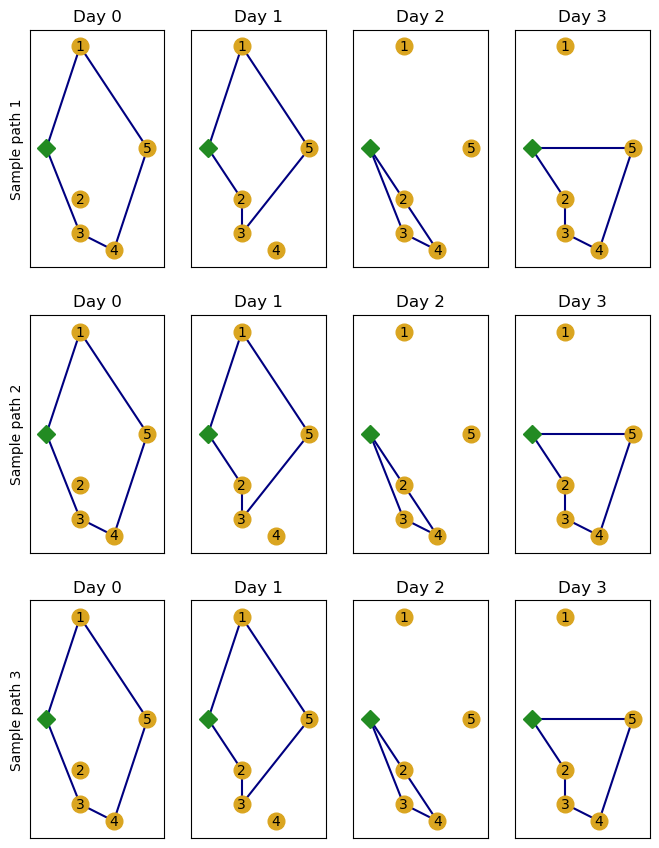

In [186]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(8,10.5))

for s in S:
    for t in T:
        for (i,j) in A:
            if x[s][t][i,j] > 0.5:
                axes[s-1][t].plot([coor[i][0],coor[j][0]],[coor[i][1],coor[j][1]], linestyle = "-", marker=None, color="navy")

        for i in N:
            axes[s-1][t].plot(coor[i][0],coor[i][1],marker="o", markersize=12, color="goldenrod")
            axes[s-1][t].text(x=coor[i][0], y=coor[i][1], s=i, va="center", ha="center")
        axes[s-1][t].plot(coor[0][0],coor[0][1], marker="D", markersize=9, color="forestgreen")

        axes[s-1][t].set_xticks([]); axes[s-1][t].set_yticks([])
        axes[s-1][t].set_xlim(30, 70); axes[s-1][t].set_ylim(0, 70); axes[s-1][t].set_title(f"Day {t}")
    axes[s-1][0].set_ylabel(f"Sample path {s}")

